In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import pickle

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.metrics import confusion_matrix

from medclip import MedCLIPModel, constants
from medclip.dataset import ZeroShotImageDataset, ZeroShotImageCollator
from medclip.prompts import generate_chexpert_class_prompts
from medclip.prototyping import compute_embeddings_over_loader, construct_prototypes, classify_with_prototypes, tokenize_all_prompts

In [ ]:
# precomputing the fused embeddings for calibration and test data (requires model forward pass)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load model and processor
model = MedCLIPModel.from_pretrained(vision_model="vit", device=device)
model.eval()

# Define disease classes
disease_classes = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Pleural Effusion"]

# Generate prompts for each class
prompts_per_class = 15
cls_prompts = generate_chexpert_class_prompts(n=prompts_per_class)

tokenizer = AutoTokenizer.from_pretrained(constants.BERT_TYPE)
tokenizer.model_max_length = 77
all_tokenized = tokenize_all_prompts(tokenizer, cls_prompts, disease_classes, device)


# step 1: calibration data
calib_data_name = "nih-sampled-calib"
calib_dataset = ZeroShotImageDataset(datalist=[calib_data_name], class_names=disease_classes)
calib_collator = ZeroShotImageCollator(mode="multiclass", cls_prompts=cls_prompts)
calib_loader = DataLoader(calib_dataset, batch_size=32, collate_fn=calib_collator, shuffle=False)

calib_results = compute_embeddings_over_loader(
    model=model,
    dataloader=calib_loader,
    all_tokenized=all_tokenized,
    num_classes=len(disease_classes),
    prompts_per_class=prompts_per_class,
    device=device,
    collect_for_calibration=True,
    concat=True,
)

all_image_embeddings = calib_results["image_embeddings"]
all_fused_embeddings = calib_results["fused_embeddings"]
all_labels = calib_results["labels"]
calib_class_logits = calib_results["class_logits"]
# calib_preds = calib_results["preds"]
# calib_correct_mask = calib_results["correct_mask"]

print(f"Image embeddings shape: {all_image_embeddings.shape}")
print(f"Fused embeddings shape: {all_fused_embeddings.shape}")
print(f"Labels shape: {all_labels.shape}")
print(f"Class logits shape: {calib_class_logits.shape}")
print(f"\nCalibration Fusion complete: {all_fused_embeddings.shape[0]} samples processed")


# Step 2: Test data
print("Processing test data...")
test_dataset = ZeroShotImageDataset(datalist=["nih-sampled-test"], class_names=disease_classes)
test_collator = ZeroShotImageCollator(mode="multiclass", cls_prompts=cls_prompts)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=test_collator, shuffle=False)

test_results = compute_embeddings_over_loader(
    model=model,
    dataloader=test_loader,
    all_tokenized=all_tokenized,
    num_classes=len(disease_classes),
    prompts_per_class=prompts_per_class,
    device=device,
    collect_for_calibration=False,
    concat=True,
)

test_fused_embeddings = test_results["fused_embeddings"]
test_labels = test_results["labels"]

print(f"Test fused embeddings shape: {test_fused_embeddings.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"\nTest Fusion complete: {test_fused_embeddings.shape[0]} samples processed")

/Users/dongyoun/miniconda3/envs/medclip_eval/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/dongyoun/miniconda3/envs/medclip_eval/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another tas

Model moved to mps
load model weight from: pretrained/medclip-vit
sample 15 num of prompts for Atelectasis from total 210
sample 15 num of prompts for Cardiomegaly from total 15
sample 15 num of prompts for Consolidation from total 192
sample 15 num of prompts for Edema from total 18
sample 15 num of prompts for Pleural Effusion from total 54
load data from ./local_data/nih-sampled-calib-meta.csv


/Users/dongyoun/miniconda3/envs/medclip_eval/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Image embeddings shape: torch.Size([2000, 512])
Fused embeddings shape: torch.Size([2000, 1024])
Labels shape: torch.Size([2000])
Class logits shape: torch.Size([2000, 5])

Calibration Fusion complete: 2000 samples processed
Processing test data...
load data from ./local_data/nih-sampled-test-meta.csv


/Users/dongyoun/miniconda3/envs/medclip_eval/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test fused embeddings shape: torch.Size([5000, 1024])
Test labels shape: torch.Size([5000])

Test Fusion complete: 5000 samples processed


In [11]:
# step 3: construct prototypes
prototypes_list = []
accuracies_list = []
per_class_accuracies_list = []
shots = list(range(1, 51)) + list(range(60, 201, 10))

for k in shots:
    prototypes = construct_prototypes(
    calib_results=calib_results,
    disease_classes=disease_classes,
    top_k=k,
)
    prototypes_list.append(prototypes)

for k, prototypes in zip(shots, prototypes_list):
    predictions, accuracy, per_class_acc, cm = classify_with_prototypes(test_fused_embeddings, test_labels, prototypes, disease_classes)
    accuracies_list.append(accuracy)
    per_class_accuracies_list.append(per_class_acc)
    
    print(f"Top {k} shots:")
    print(f"\nPrototype-based classifier accuracy: {accuracy:.4f}")
    print("Per-class accuracy:")
    for name, acc in per_class_acc.items():
        print(f"  {name:20s}: {acc:.4f}")

Top 1 shots:

Prototype-based classifier accuracy: 0.5326
Per-class accuracy:
  Atelectasis         : 0.6080
  Cardiomegaly        : 0.5440
  Consolidation       : 0.1240
  Edema               : 0.7080
  Pleural Effusion    : 0.6790
Top 2 shots:

Prototype-based classifier accuracy: 0.5420
Per-class accuracy:
  Atelectasis         : 0.5940
  Cardiomegaly        : 0.6400
  Consolidation       : 0.2080
  Edema               : 0.6130
  Pleural Effusion    : 0.6550
Top 3 shots:

Prototype-based classifier accuracy: 0.5416
Per-class accuracy:
  Atelectasis         : 0.5740
  Cardiomegaly        : 0.6290
  Consolidation       : 0.2380
  Edema               : 0.6000
  Pleural Effusion    : 0.6670
Top 4 shots:

Prototype-based classifier accuracy: 0.5336
Per-class accuracy:
  Atelectasis         : 0.4880
  Cardiomegaly        : 0.6850
  Consolidation       : 0.2310
  Edema               : 0.6090
  Pleural Effusion    : 0.6550
Top 5 shots:

Prototype-based classifier accuracy: 0.5346
Per-class 

In [ ]:
# Save embeddings
save_data = {
    'prototypes_list': prototypes_list,
    'shots': shots,
    'test_fused_embeddings': test_fused_embeddings,
    'test_labels': test_labels,
    'disease_classes': disease_classes,
    'accuracies_list': accuracies_list,
}

with open('fusion_prototypes_data.pkl', 'wb') as f:
    pickle.dump(save_data, f)

print("Data saved successfully!")
print(f"Saved {len(prototypes_list)} prototype sets for shots: {shots}")
print(f"Test embeddings shape: {test_fused_embeddings.shape}")
print(f"Test labels shape: {test_labels.shape}")


Data saved successfully!
Saved 65 prototype sets for shots: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
Test embeddings shape: torch.Size([5000, 1024])
Test labels shape: torch.Size([5000])


In [ ]:
# Load the saved data (or just use the variables already in memory)

# with open('fusion_prototypes_data.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)

# prototypes_list = loaded_data['prototypes_list']
# shots = loaded_data['shots']
# test_fused_embeddings = loaded_data['test_fused_embeddings']
# test_labels = loaded_data['test_labels']
# disease_classes = loaded_data['disease_classes']
# accuracies_list = loaded_data['accuracies_list']

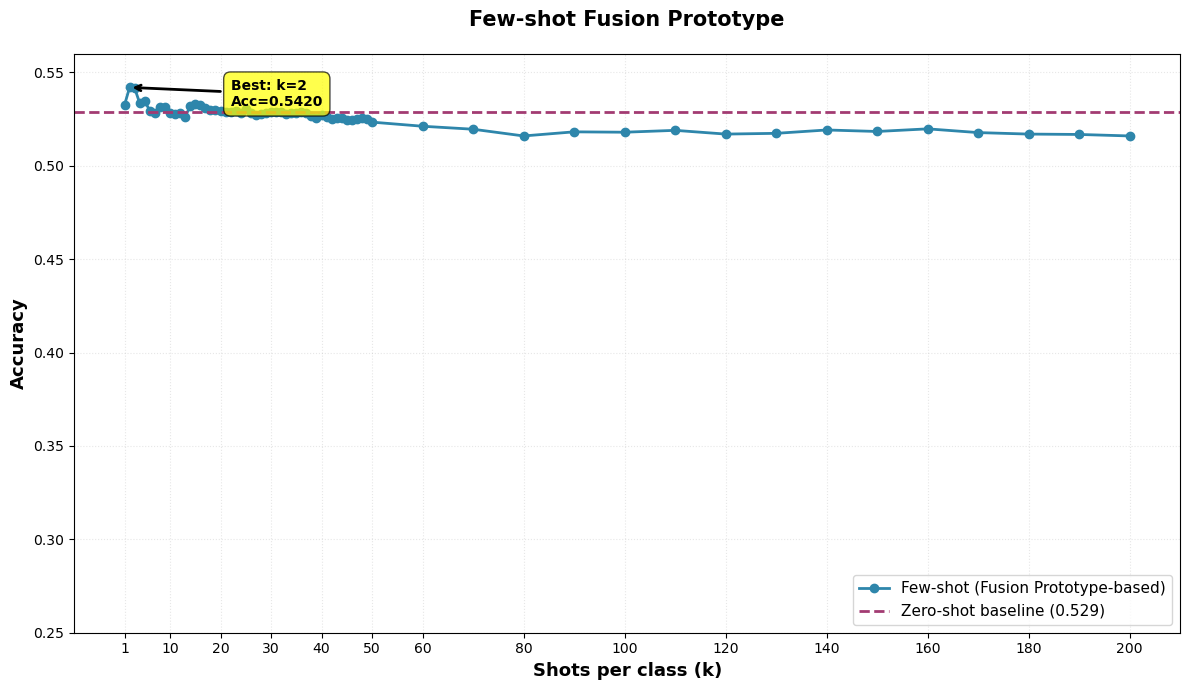


Zero-shot baseline: 0.5290
Best few-shot accuracy: 0.5420 at k=2
Improvement over zero-shot: 0.0130 (2.46%)

Plot saved to 'few_shot_fusion_prototype.png'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot accuracy vs shots
zero_shot_baseline = 0.529

plt.figure(figsize=(12, 7))

# Plot few-shot accuracies
plt.plot(shots, accuracies_list, 'o-', linewidth=2, markersize=6, 
         label='Few-shot (Fusion Prototype-based)', color='#2E86AB')

# Add zero-shot baseline
plt.axhline(y=zero_shot_baseline, color='#A23B72', linestyle='--', 
            linewidth=2, label=f'Zero-shot baseline ({zero_shot_baseline:.3f})')

# Formatting
plt.xlabel('Shots per class (k)', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.title('Few-shot Fusion Prototype', 
          fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3, linestyle=':')

# Set axis limits to match reference plot
plt.ylim(0.25, 0.56)

# Set x-axis to show key points
xticks = [1, 10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200]
plt.xticks(xticks, fontsize=10)
plt.yticks(fontsize=10)

# Add annotations for best performance
best_idx = np.argmax(accuracies_list)
best_k = shots[best_idx]
best_acc = accuracies_list[best_idx]
plt.annotate(f'Best: k={best_k}\nAcc={best_acc:.4f}', 
             xy=(best_k, best_acc), xytext=(best_k + 20, best_acc - 0.01),
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', lw=2, color='black'))

plt.tight_layout()
save_path = 'imgs/few_shot_fusion_prototype.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nZero-shot baseline: {zero_shot_baseline:.4f}")
print(f"Best few-shot accuracy: {best_acc:.4f} at k={best_k}")
print(f"Improvement over zero-shot: {(best_acc - zero_shot_baseline):.4f} ({(best_acc - zero_shot_baseline) / zero_shot_baseline * 100:.2f}%)")
print(f"\nPlot saved to '{save_path}'")


Visualizing prototypes for: Pleural Effusion
K values: [2, 10, 20, 30, 40, 50, 60]
Number of classes: 5
Focus class test embeddings shape: (1000, 1024)
Focus class prototype embeddings shape: (7, 1024)
Number of prototypes: 7 k-values for Pleural Effusion
Combined embeddings shape for t-SNE: (1007, 1024)
Applying t-SNE (this may take a moment)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1007 samples in 0.002s...
[t-SNE] Computed neighbors for 1007 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1007
[t-SNE] Computed conditional probabilities for sample 1007 / 1007
[t-SNE] Mean sigma: 0.059905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.380341
[t-SNE] KL divergence after 1000 iterations: 1.095354
t-SNE complete! Creating visualization...
Test embeddings 2D shape: (1000, 2)
Prototype embeddings 2D shape: (7, 2)


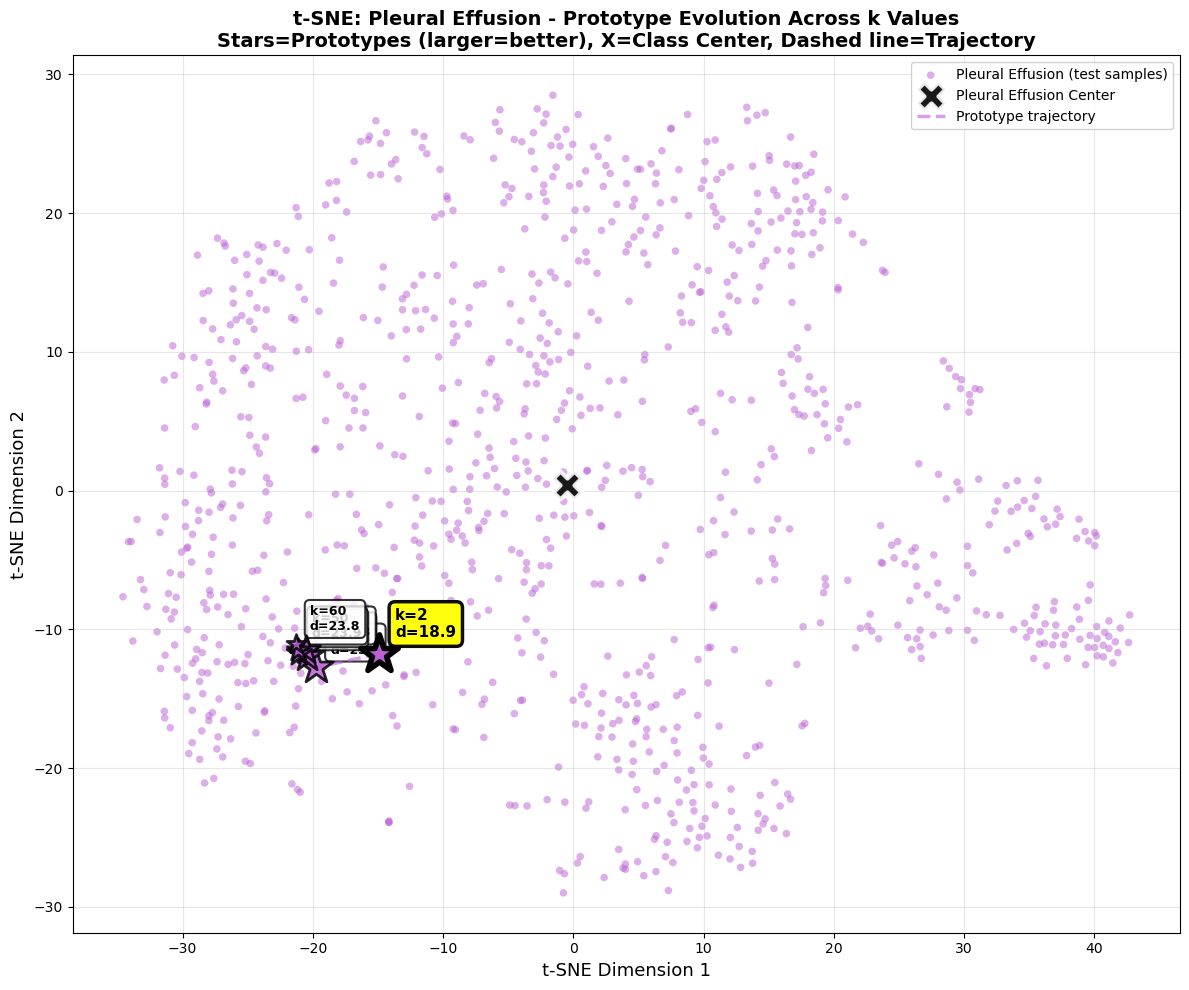


Visualization saved to 'imgs/tsne_pleural_effusion_prototypes.png'

Pleural Effusion Prototype Analysis:
Class center position: (-0.47, 0.41)

Prototype positions and distances from class center:
  k= 2: pos=( -14.96,  -11.77), distance= 18.93  ⭐ BEST
  k=10: pos=( -19.74,  -12.75), distance= 23.34
  k=20: pos=( -20.45,  -11.93), distance= 23.49
  k=30: pos=( -20.50,  -11.52), distance= 23.31
  k=40: pos=( -21.08,  -11.71), distance= 23.91
  k=50: pos=( -21.15,  -11.52), distance= 23.88
  k=60: pos=( -21.30,  -11.05), distance= 23.78

Accuracy for Pleural Effusion at different k values:
  k= 2: accuracy=0.6550  ⭐ BEST
  k=10: accuracy=0.6290
  k=20: accuracy=0.6100
  k=30: accuracy=0.6150
  k=40: accuracy=0.6010
  k=50: accuracy=0.6000
  k=60: accuracy=0.5970


In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Select k values to visualize
k_values = [2, 10, 20, 30, 40, 50, 60]

# Choose which disease class to visualize (0-4)
# 0: Atelectasis, 1: Cardiomegaly, 2: Consolidation, 3: Edema, 4: Pleural Effusion
focus_class_idx = 4  # Change this to visualize different classes
focus_class_name = disease_classes[focus_class_idx]

print(f"Visualizing prototypes for: {focus_class_name}")
print(f"K values: {k_values}")
print(f"Number of classes: {len(disease_classes)}")

# Convert test embeddings and labels to numpy if they're tensors
test_emb_np = test_fused_embeddings.cpu().numpy() if hasattr(test_fused_embeddings, 'cpu') else test_fused_embeddings
test_labels_np = test_labels.cpu().numpy() if hasattr(test_labels, 'cpu') else test_labels

# Extract prototype embeddings ONLY for the focus class
focus_prototype_embeddings = []
focus_prototype_k_values = []

for k in k_values:
    k_idx = shots.index(k)
    prototypes_k = prototypes_list[k_idx]
    
    # Only get the prototype for the focus class
    proto = prototypes_k[focus_class_name]
    proto_np = proto.cpu().numpy() if hasattr(proto, 'cpu') else proto
    focus_prototype_embeddings.append(proto_np)
    focus_prototype_k_values.append(k)

focus_prototype_embeddings = np.array(focus_prototype_embeddings)
focus_prototype_k_values = np.array(focus_prototype_k_values)

# Filter test embeddings to only the focus class
focus_class_mask = test_labels_np == focus_class_idx
test_emb_focus = test_emb_np[focus_class_mask]

print(f"Focus class test embeddings shape: {test_emb_focus.shape}")
print(f"Focus class prototype embeddings shape: {focus_prototype_embeddings.shape}")
print(f"Number of prototypes: {len(k_values)} k-values for {focus_class_name}")

# Combine test embeddings and prototypes for t-SNE
all_embeddings = np.vstack([test_emb_focus, focus_prototype_embeddings])
print(f"Combined embeddings shape for t-SNE: {all_embeddings.shape}")

# Apply t-SNE
print("Applying t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Split back into test and prototype embeddings
test_emb_2d = embeddings_2d[:len(test_emb_focus)]
proto_emb_2d = embeddings_2d[len(test_emb_focus):]

print("t-SNE complete! Creating visualization...")
print(f"Test embeddings 2D shape: {test_emb_2d.shape}")
print(f"Prototype embeddings 2D shape: {proto_emb_2d.shape}")

# Calculate class center
class_center_x = np.mean(test_emb_2d[:, 0])
class_center_y = np.mean(test_emb_2d[:, 1])

# Create visualization
plt.figure(figsize=(12, 10))

# Define color for the focus class
colors = ['#CC665D', '#C0D96B', '#7DD79A', '#6084D5', '#BB61D5']
focus_color = colors[focus_class_idx]

# Plot test embeddings for the focus class only
plt.scatter(
    test_emb_2d[:, 0], 
    test_emb_2d[:, 1],
    c=focus_color,
    label=f'{focus_class_name} (test samples)',
    alpha=0.5,
    s=30,
    edgecolors='none'
)

# Plot class center
plt.scatter(class_center_x, class_center_y, marker='X', s=400, c='black', 
            linewidths=3, edgecolors='white', zorder=20, alpha=0.9,
            label=f'{focus_class_name} Center')

# Draw trajectory line connecting all prototypes
proto_x_coords = proto_emb_2d[:, 0]
proto_y_coords = proto_emb_2d[:, 1]
plt.plot(proto_x_coords, proto_y_coords, 
         color=focus_color, linestyle='--', linewidth=2.5, alpha=0.6, zorder=5,
         label='Prototype trajectory')

# Plot prototypes for all k values with different sizes
# k=2 (best) will be largest, others progressively smaller
marker_sizes = {2: 800, 10: 650, 20: 550, 30: 450, 40: 350, 50: 280, 60: 200}

for k_idx, k in enumerate(k_values):
    # Emphasize k=2 (best performance)
    edge_width = 4 if k == 2 else 2
    alpha_val = 1.0 if k == 2 else 0.85
    
    # Plot prototype
    plt.scatter(
        proto_emb_2d[k_idx, 0],
        proto_emb_2d[k_idx, 1],
        c=focus_color,
        marker='*',
        s=marker_sizes[k],
        edgecolors='black',
        linewidths=edge_width,
        alpha=alpha_val,
        zorder=15 if k == 2 else 10 + k_idx
    )
    
    # Calculate distance from class center
    distance = np.sqrt((proto_emb_2d[k_idx, 0] - class_center_x)**2 + 
                      (proto_emb_2d[k_idx, 1] - class_center_y)**2)
    
    # Add text label next to prototype
    fontsize = 11 if k == 2 else 9
    plt.annotate(
        f'k={k}\nd={distance:.1f}',
        xy=(proto_emb_2d[k_idx, 0], proto_emb_2d[k_idx, 1]),
        xytext=(12, 12) if k == 2 else (10, 10),
        textcoords='offset points',
        fontsize=fontsize,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.4', 
                 facecolor='yellow' if k == 2 else 'white', 
                 alpha=0.95 if k == 2 else 0.8, 
                 edgecolor='black', 
                 linewidth=2.5 if k == 2 else 1.5),
    )

plt.title(f't-SNE: {focus_class_name} - Prototype Evolution Across k Values\n' + 
          f'Stars=Prototypes (larger=better), X=Class Center, Dashed line=Trajectory', 
          fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=13)
plt.ylabel('t-SNE Dimension 2', fontsize=13)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

save_path = f'imgs/tsne_{focus_class_name.lower().replace(" ", "_")}_prototypes.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*80}")
print(f"Visualization saved to '{save_path}'")
print(f"{'='*80}")

# Print detailed statistics
print(f"\n{focus_class_name} Prototype Analysis:")
print(f"Class center position: ({class_center_x:.2f}, {class_center_y:.2f})")
print(f"\nPrototype positions and distances from class center:")
for k_idx, k in enumerate(k_values):
    distance = np.sqrt((proto_emb_2d[k_idx, 0] - class_center_x)**2 + 
                      (proto_emb_2d[k_idx, 1] - class_center_y)**2)
    marker = "  ⭐ BEST" if k == 2 else ""
    print(f"  k={k:2d}: pos=({proto_emb_2d[k_idx, 0]:7.2f}, {proto_emb_2d[k_idx, 1]:7.2f}), "
          f"distance={distance:6.2f}{marker}")

# Calculate accuracy for this class at different k values
print(f"\nAccuracy for {focus_class_name} at different k values:")
for k_idx, k in enumerate(k_values):
    k_shot_idx = shots.index(k)
    acc = per_class_accuracies_list[k_shot_idx][focus_class_name]
    marker = "  ⭐ BEST" if k == 2 else ""
    print(f"  k={k:2d}: accuracy={acc:.4f}{marker}")
